<a href="https://colab.research.google.com/github/BonanYang/GNN/blob/main/GNN_on_OGBN_Products_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -c "import torch; print(torch.version.cuda)"

12.6


In [2]:

!python -c "import torch; print(torch.__version__)"

2.9.0+cu126


In [3]:
%%capture
!pip install pyg-lib torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.9.0+cu126.html
!pip install torch-geometric ogb

In [9]:
import torch
_original_load = torch.load
def _patched_load(*args, **kwargs):
    kwargs['weights_only'] = False
    return _original_load(*args, **kwargs)
torch.load = _patched_load
import torch.nn.functional as F
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch_geometric.transforms as T
from torch_geometric.data import NeighborSampler
from torch_geometric.nn import SAGEConv, GCNConv
from torch_geometric import utils, loader
from torch_geometric.utils import subgraph

from torch_geometric.nn import (
    Aggregation,
    MaxAggregation,
    MeanAggregation,
    MultiAggregation,
    SoftmaxAggregation,
    StdAggregation,
    SumAggregation,
    VarAggregation,
    LSTMAggregation
)

from ogb.nodeproppred import PygNodePropPredDataset
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

from pandas.core.common import flatten
import matplotlib.pyplot as plt
from collections import Counter


from tqdm import tqdm
import collections
import os.path as osp
import pandas as pd
import numpy as np
import collections

import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)



In [6]:
opt = 'GCN'

In [7]:
evaluator = Evaluator(name='ogbn-products')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [10]:
root = osp.join(osp.dirname(osp.realpath('./')), 'content')
if opt == 'GCN':
  dataset = PygNodePropPredDataset( name='ogbn-products', root=root)
else:
  dataset = PygNodePropPredDataset( name='ogbn-products', transform=T.ToSparseTensor(), root=root)

In [11]:
data = dataset[0]

In [13]:
subset_indices = torch.arange(0, 10000)
subset_edge_index, edge_attr, edge_mask = subgraph(subset_indices, data.edge_index, None, relabel_nodes=True, num_nodes=data.num_nodes, return_edge_mask=True)
subset_features = data.x[subset_indices]
subset_labels = data.y[subset_indices]
subset_graph = data.__class__()
subset_graph.edge_index = subset_edge_index
subset_graph.x = subset_features
subset_graph.y = subset_labels

In [14]:
path_to_file = '/content/ogbn_products/mapping/labelidx2productcategory.csv.gz'
df = pd.read_csv(path_to_file)
index_product_dict = dict(zip(df['label idx'], df['product category']))

In [15]:
path_to_asin_file = '/content/ogbn_products/mapping/nodeidx2asin.csv.gz'
asin_df = pd.read_csv(path_to_asin_file)
node_asin_dict = dict(zip(asin_df['node idx'], asin_df['asin']))

In [16]:
print(f"Number of nodes in the subgraph: {subset_graph.num_nodes}")
print(f"Number of edges in the subgraph: {subset_graph.num_edges}")

Number of nodes in the subgraph: 10000
Number of edges in the subgraph: 27632


In [17]:
subset_graph

Data(edge_index=[2, 27632], x=[10000, 100], y=[10000, 1])

In [18]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, return_embeds=False):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        if return_embeds:
            return x
        return torch.log_softmax(x, dim=1)



gcn_model = GCN(in_channels=dataset.num_features, hidden_channels=64, out_channels=dataset.num_classes)



class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index, return_embeds=False):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        if return_embeds:
            return x
        return torch.log_softmax(x, dim=1)

graphsage_model = GraphSAGE(in_channels=dataset.num_features, hidden_channels=64, out_channels=dataset.num_classes)


optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    gcn_model.train()
    optimizer.zero_grad()
    out = gcn_model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()



In [19]:
subset_graph.num_features = subset_graph.x.size(1)

subset_graph.y = subset_graph.y.squeeze()
if subset_graph.y.dim() == 1:
    num_classes = int(subset_graph.y.max().item()) + 1

elif subset_graph.y.dim() == 2:
    num_classes = subset_graph.y.size(1)

subset_graph.num_classes = num_classes

In [20]:
num_classes, subset_graph.num_features

(32, 100)

In [22]:

def generate_split_masks(num_nodes, train_frac=0.6, val_frac=0.2, test_frac=0.2):

    assert train_frac + val_frac + test_frac == 1, " sum up to 1."

    indices = torch.randperm(num_nodes)
    train_size = int(num_nodes * train_frac)
    val_size = int(num_nodes * val_frac)

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size + val_size]] = True
    test_mask[indices[train_size + val_size:]] = True

    return {'train_mask': train_mask, 'val_mask': val_mask, 'test_mask': test_mask}

subset_masks = generate_split_masks(num_nodes=subset_graph.num_nodes)

subset_graph.train_mask = subset_masks['train_mask']
subset_graph.val_mask = subset_masks['val_mask']
subset_graph.test_mask = subset_masks['test_mask']


In [23]:
gcn_model = GCN(in_channels=subset_graph.num_features, hidden_channels=64, out_channels=subset_graph.num_classes)
graphsage_model = GraphSAGE(in_channels=subset_graph.num_features, hidden_channels=64, out_channels=subset_graph.num_classes)

optimizer_gcn = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
optimizer_sage = torch.optim.Adam(graphsage_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

best_val_loss_gcn = float('inf')
best_model_state_gcn = None

best_val_loss_sage = float('inf')
best_model_state_sage = None

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask].squeeze())  # Ensure the target tensor is of the correct shape
    loss.backward()
    optimizer.step()
    return loss.item()


Epoch 0, GCN Loss: 3.6302, GraphSAGE Loss: 3.6705, GCN Val Loss: 3.2669, GraphSAGE Val Loss: 3.2093
Epoch 10, GCN Loss: 1.5913, GraphSAGE Loss: 1.3031, GCN Val Loss: 1.5525, GraphSAGE Val Loss: 1.3168
Epoch 20, GCN Loss: 1.0645, GraphSAGE Loss: 0.8571, GCN Val Loss: 1.1445, GraphSAGE Val Loss: 1.0839
Epoch 30, GCN Loss: 0.8417, GraphSAGE Loss: 0.6463, GCN Val Loss: 1.0219, GraphSAGE Val Loss: 1.0545
Epoch 40, GCN Loss: 0.7039, GraphSAGE Loss: 0.4900, GCN Val Loss: 0.9715, GraphSAGE Val Loss: 1.0439
Epoch 50, GCN Loss: 0.6079, GraphSAGE Loss: 0.3757, GCN Val Loss: 0.9397, GraphSAGE Val Loss: 1.0542
Epoch 60, GCN Loss: 0.5359, GraphSAGE Loss: 0.2916, GCN Val Loss: 0.9335, GraphSAGE Val Loss: 1.1115
Epoch 70, GCN Loss: 0.4769, GraphSAGE Loss: 0.2276, GCN Val Loss: 0.9422, GraphSAGE Val Loss: 1.1797
Epoch 80, GCN Loss: 0.4273, GraphSAGE Loss: 0.1794, GCN Val Loss: 0.9630, GraphSAGE Val Loss: 1.2613
Epoch 90, GCN Loss: 0.3848, GraphSAGE Loss: 0.1437, GCN Val Loss: 0.9875, GraphSAGE Val Loss

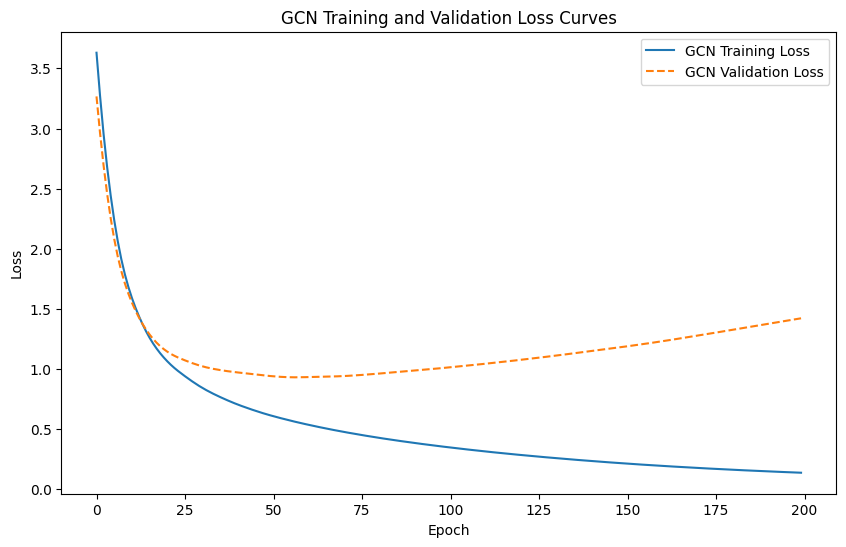

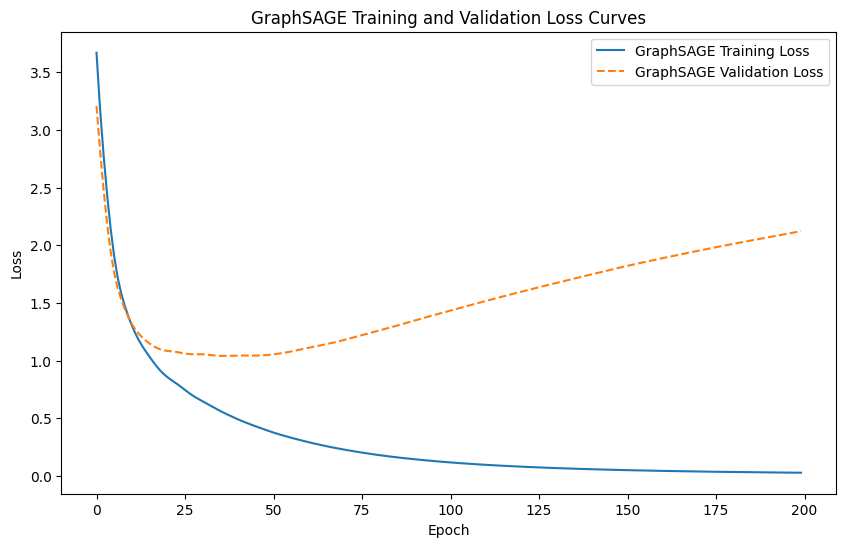

In [24]:
train_loss_gcn = []
val_loss_gcn = []
train_loss_sage = []
val_loss_sage = []

def validate(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask].squeeze())  # Make sure the target tensor is of the correct shape
    return val_loss.item()

for epoch in range(200):
    loss_gcn = train(gcn_model, optimizer_gcn, subset_graph)
    train_loss_gcn.append(loss_gcn)
    current_val_loss_gcn = validate(gcn_model, subset_graph)
    val_loss_gcn.append(current_val_loss_gcn)
    if current_val_loss_gcn < best_val_loss_gcn:
        best_val_loss_gcn = current_val_loss_gcn
        best_model_state_gcn = gcn_model.state_dict()

    loss_sage = train(graphsage_model, optimizer_sage, subset_graph)
    train_loss_sage.append(loss_sage)
    current_val_loss_sage = validate(graphsage_model, subset_graph)
    val_loss_sage.append(current_val_loss_sage)

    if current_val_loss_sage < best_val_loss_sage:
        best_val_loss_sage = current_val_loss_sage
        best_model_state_sage = graphsage_model.state_dict()


    if epoch % 10 == 0:
        print(f'Epoch {epoch}, GCN Loss: {loss_gcn:.4f}, GraphSAGE Loss: {loss_sage:.4f}, GCN Val Loss: {val_loss_gcn[-1]:.4f}, GraphSAGE Val Loss: {val_loss_sage[-1]:.4f}')
gcn_model.load_state_dict(best_model_state_gcn)
graphsage_model.load_state_dict(best_model_state_sage)


def test_model(model, data):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        out = model(data.x.to(device), data.edge_index.to(device))  # Forward pass
        preds = torch.argmax(out, dim=1)[data.test_mask]  # Only take the predictions from the test mask
        true_labels = data.y[data.test_mask]  # True labels for the test data
    return preds.cpu().numpy(), true_labels.cpu().numpy()

# Plotting the training and validation loss curves for GCN
plt.figure(figsize=(10, 6))
plt.plot(train_loss_gcn, label='GCN Training Loss')
plt.plot(val_loss_gcn, label='GCN Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GCN Training and Validation Loss Curves')
plt.legend()
plt.show()

# Plotting the training and validation loss curves for GraphSAGE
plt.figure(figsize=(10, 6))
plt.plot(train_loss_sage, label='GraphSAGE Training Loss')
plt.plot(val_loss_sage, label='GraphSAGE Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GraphSAGE Training and Validation Loss Curves')
plt.legend()
plt.show()


In [25]:
import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

def evaluate(model, data, mask):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        logits = model(data.x, data.edge_index)  # Forward pass
        preds = logits.argmax(dim=1)  # Get the predicted classes

        # Calculate F1 score
        f1 = f1_score(data.y[mask].cpu().numpy(), preds[mask].cpu().numpy(), average='weighted')

        # Calculate log loss using PyTorch's NLLLoss
        log_probs = F.log_softmax(logits[mask], dim=1)
        loss_function = torch.nn.NLLLoss()
        logloss = loss_function(log_probs, data.y[mask])

    return f1, logloss.item()

# Example usage
f1_gcn, logloss_gcn = evaluate(gcn_model, subset_graph, subset_graph.val_mask)  # Evaluate GCN on validation set
f1_sage, logloss_sage = evaluate(graphsage_model, subset_graph, subset_graph.val_mask)  # Evaluate GraphSAGE on validation set

print(f"GCN F1 Score: {f1_gcn:.4f}, Log Loss: {logloss_gcn:.4f}")
print(f"GraphSAGE F1 Score: {f1_sage:.4f}, Log Loss: {logloss_sage:.4f}")


GCN F1 Score: 0.7809, Log Loss: 1.4221
GraphSAGE F1 Score: 0.7483, Log Loss: 2.1222


In [26]:
def analyze_category_predictions(true_labels, pred_labels):
    analysis_results = {}
    for category in set(true_labels):
        indices = [i for i, label in enumerate(true_labels) if label == category]

        if not indices:
            continue

        category_preds = [pred_labels[i] for i in indices]
        correct_preds_count = category_preds.count(category)

        mispredictions = [pred for pred in category_preds if pred != category]
        most_common_misprediction, most_common_misprediction_count = Counter(mispredictions).most_common(1)[0] if mispredictions else ("None", 0)

        analysis_results[category] = {
            'Correct Prediction Percentage': correct_preds_count / len(indices) * 100 if indices else 0,
            'Correct Prediction Count': correct_preds_count,
            'Most Common Misprediction': most_common_misprediction,
            'Misprediction Percentage': most_common_misprediction_count / len(indices) * 100 if mispredictions and indices else 0,
            'Misprediction Count': most_common_misprediction_count,
            'Total Count': len(indices)
        }

    return analysis_results

all_true_labels = [index_product_dict[label.item()] for label in subset_graph.y]

with torch.no_grad():
    gcn_all_logits = gcn_model(subset_graph.x, subset_graph.edge_index)
    gcn_all_preds = torch.argmax(gcn_all_logits, dim=1)
    gcn_all_preds = [index_product_dict[pred.item()] for pred in gcn_all_preds]

    sage_all_logits = graphsage_model(subset_graph.x, subset_graph.edge_index)
    sage_all_preds = torch.argmax(sage_all_logits, dim=1)
    sage_all_preds = [index_product_dict[pred.item()] for pred in sage_all_preds]

gcn_analysis_all = analyze_category_predictions(all_true_labels, gcn_all_preds)

# Example: Printing analysis results for the GCN model for all nodes
for category, stats in gcn_analysis_all.items():
    print(f"Category: {category}")
    print(f"GCN Correct Predictions: {stats['Correct Prediction Count']} / {stats['Total Count']} ({stats['Correct Prediction Percentage']:.2f}%)")
    print(f"GCN Most Common Misprediction: {stats['Most Common Misprediction']} - {stats['Misprediction Count']} / {stats['Total Count']} ({stats['Misprediction Percentage']:.2f}%)")
    print("-" * 50)


Category: Pet Supplies
GCN Correct Predictions: 231 / 243 (95.06%)
GCN Most Common Misprediction: Books - 5 / 243 (2.06%)
--------------------------------------------------
Category: Health & Personal Care
GCN Correct Predictions: 489 / 601 (81.36%)
GCN Most Common Misprediction: Beauty - 20 / 601 (3.33%)
--------------------------------------------------
Category: Musical Instruments
GCN Correct Predictions: 86 / 107 (80.37%)
GCN Most Common Misprediction: CDs & Vinyl - 5 / 107 (4.67%)
--------------------------------------------------
Category: CDs & Vinyl
GCN Correct Predictions: 850 / 887 (95.83%)
GCN Most Common Misprediction: Movies & TV - 15 / 887 (1.69%)
--------------------------------------------------
Category: Clothing, Shoes & Jewelry
GCN Correct Predictions: 111 / 160 (69.38%)
GCN Most Common Misprediction: Sports & Outdoors - 21 / 160 (13.12%)
--------------------------------------------------
Category: Movies & TV
GCN Correct Predictions: 503 / 559 (89.98%)
GCN Most Com

In [29]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, agg_func='mean'):
        super(GraphSAGE, self).__init__()
        self.agg_func = agg_func
        self.conv1 = SAGEConv(in_channels, hidden_channels, self.agg_func)
        self.conv2 = SAGEConv(hidden_channels, out_channels, self.agg_func)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.log_softmax(x, dim=1)


In [30]:
def train_evaluate(agg_func):
    model = GraphSAGE(in_channels=subset_graph.num_features, hidden_channels=64, out_channels=dataset.num_classes, agg_func=agg_func).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(100):  # You can adjust the number of epochs
        model.train()
        optimizer.zero_grad()
        out = model(subset_graph.x.to(device), subset_graph.edge_index.to(device))
        loss = criterion(out[subset_graph.train_mask], subset_graph.y[subset_graph.train_mask].squeeze().to(device))
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                preds = out.argmax(dim=1)
                correct = (preds[subset_graph.val_mask] == subset_graph.y[subset_graph.val_mask].squeeze().to(device)).sum()
                acc = int(correct) / int(subset_graph.val_mask.sum())
                print(f'Epoch: {epoch}, Loss: {loss.item():.4f}, Val Acc: {acc:.4f}')

    return acc

# Aggregation functions to test
aggregations = ['mean', 'sum', 'max']

# Evaluate models with different aggregation functions
for agg in aggregations:
    print(f'\nTesting with {agg} aggregation:')
    acc = train_evaluate(agg)
    print(f'Validation Accuracy with {agg} aggregation: {acc:.4f}\n')



Testing with mean aggregation:
Epoch: 0, Loss: 3.8095, Val Acc: 0.1030
Epoch: 10, Loss: 1.3058, Val Acc: 0.6765
Epoch: 20, Loss: 0.8611, Val Acc: 0.7490
Epoch: 30, Loss: 0.6409, Val Acc: 0.7570
Epoch: 40, Loss: 0.4849, Val Acc: 0.7615
Epoch: 50, Loss: 0.3725, Val Acc: 0.7650
Epoch: 60, Loss: 0.2868, Val Acc: 0.7625
Epoch: 70, Loss: 0.2222, Val Acc: 0.7650
Epoch: 80, Loss: 0.1737, Val Acc: 0.7640
Epoch: 90, Loss: 0.1375, Val Acc: 0.7610
Validation Accuracy with mean aggregation: 0.7610


Testing with sum aggregation:
Epoch: 0, Loss: 5.7803, Val Acc: 0.0105
Epoch: 10, Loss: 1.3350, Val Acc: 0.7015
Epoch: 20, Loss: 0.9391, Val Acc: 0.7335
Epoch: 30, Loss: 0.6940, Val Acc: 0.7545
Epoch: 40, Loss: 0.5304, Val Acc: 0.7625
Epoch: 50, Loss: 0.4162, Val Acc: 0.7650
Epoch: 60, Loss: 0.3345, Val Acc: 0.7735
Epoch: 70, Loss: 0.2712, Val Acc: 0.7705
Epoch: 80, Loss: 0.2218, Val Acc: 0.7705
Epoch: 90, Loss: 0.1836, Val Acc: 0.7695
Validation Accuracy with sum aggregation: 0.7695


Testing with max 

/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/_scatter.py:91: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(


Epoch: 10, Loss: 1.5403, Val Acc: 0.6315
Epoch: 20, Loss: 0.9644, Val Acc: 0.7180
Epoch: 30, Loss: 0.7072, Val Acc: 0.7385
Epoch: 40, Loss: 0.5363, Val Acc: 0.7490
Epoch: 50, Loss: 0.4090, Val Acc: 0.7525
Epoch: 60, Loss: 0.3160, Val Acc: 0.7510
Epoch: 70, Loss: 0.2478, Val Acc: 0.7485
Epoch: 80, Loss: 0.1971, Val Acc: 0.7495
Epoch: 90, Loss: 0.1594, Val Acc: 0.7495
Validation Accuracy with max aggregation: 0.7495

